<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Very_Deep_Convolutional_Networks_for_Large_Scale_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Very Deep Convolutional Networks for Large-Scale Image Recognition**

논문 링크: https://arxiv.org/abs/1409.1556

데이터셋: http://image-net.org/download

하지만 위의 데이터셋은 다운로드 시간이 3~5일이 걸리기 때문에 실습시에는 STL10 데이터셋을 가져오도록 했다.



VGGNet은 옥스포드 대학의 연구팀 VGG에 의해 개발된 모델로써, **2014년에 개최된 ILSVRC(ImageNet Large Scale Visual Recognition Challenge)에서 준우승**을 차지한 신경망(CNN) 구조이다.

## **VGGNet 구조**

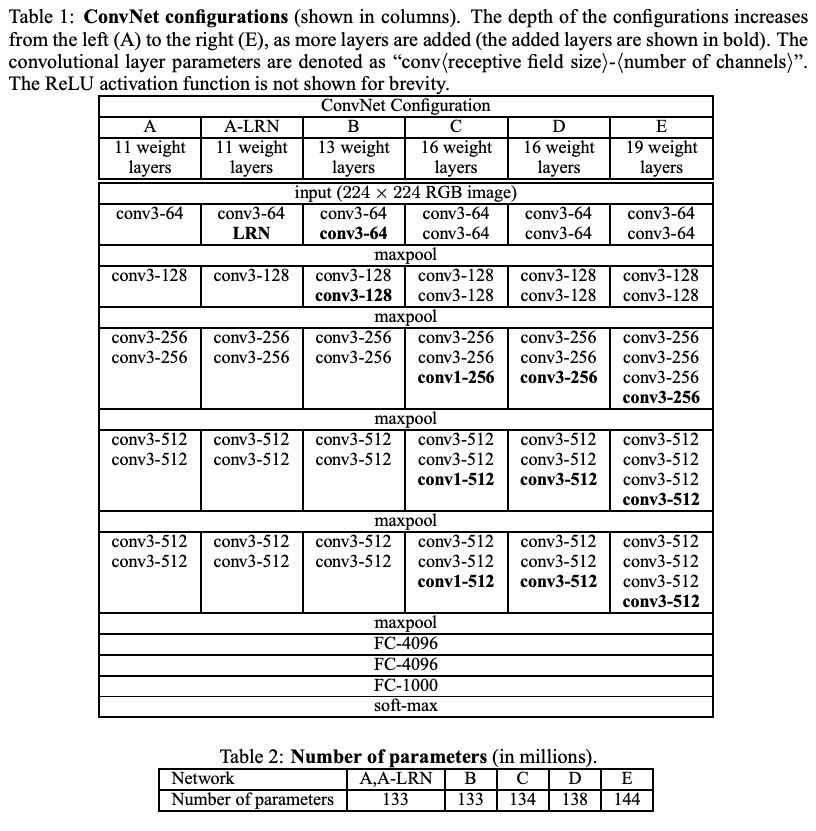

위의 표세엇 conv3은 3x3필터를, conv1은 1x1필터를 의미한다. 또한 conv3-N에서 N은 필터의 개수에 해당한다.

본 논문에서는 224 x 224 RGB 이미지에 위와 같은 아키텍처들을 사용했다. 이를 통해 VGG 모델은 딥러닝 기반 컴퓨터 비전 모델의 시대를 열었던 AlexNet(2012)의 8-layers 모델보다 깊이가 2배 이상 깊은 네트워크의 학습에 성공했으며, 이를 통해 ImageNet Challenge에서 AlexNet의 오차율을 절반(16.4 > 7.3)으로 줄였다.

이처럼 VGGNet이 16–19 레이어에 달하는 깊은 신경망을 학습할 수 있었던 이유는 **모든 합성곱 레이어에서 3x3 필터를 사용**했기 때문이다.

그리고 VGGNet의 종류에 상관없이 신경망의 **마지막 3 Fully-Connected Layer는 각각 4096, 4096, 1000** 개의 유닛으로 구성돼 있으며, 출력층(1000: class의 개수)은 classification을 위한 Softmax 함수를 사용한다.

### **3x3 Filter**

먼저 10x10의 이미지가 있다고 가정을 했을때, 7x7필터와 3x3필터로 각각 Convolution을 수행하면 다음과 같은 특성이 있다.

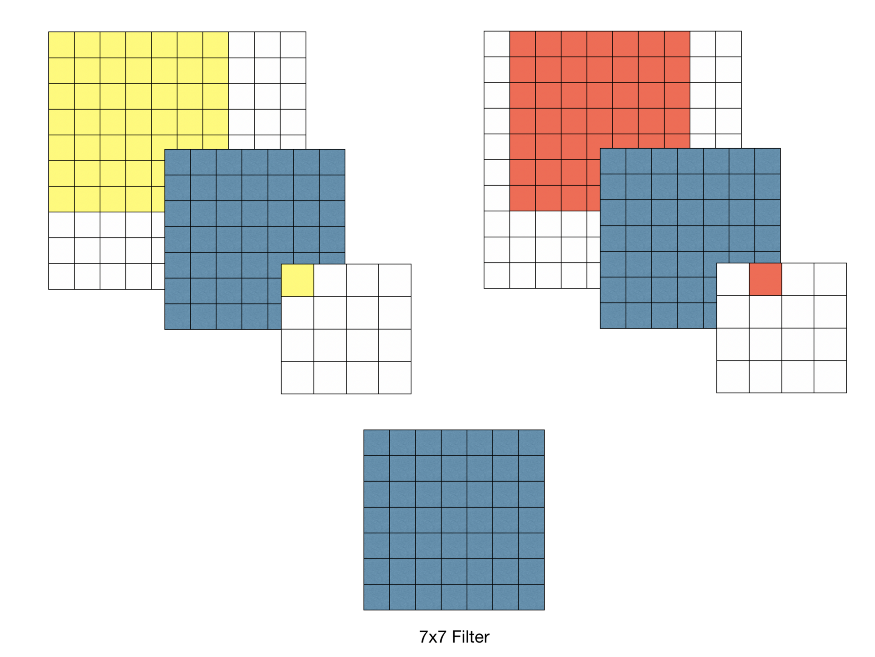

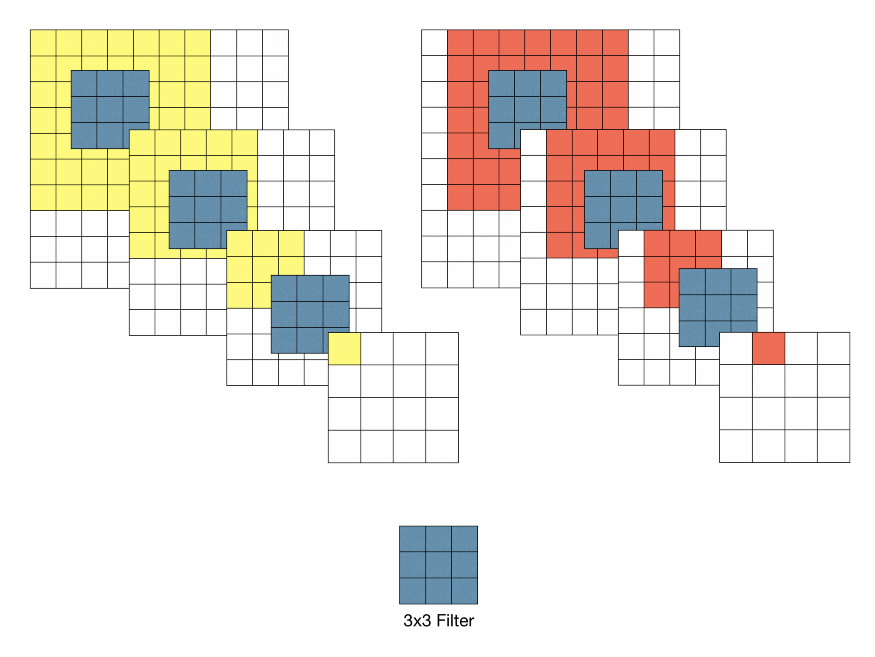

**Stride=1일 때, 3차례의 3x3 Conv 필터링을 반복한 특징맵은 한 픽셀이 원본 이미지의 7x7 Receptive field의 효과를 볼 수 있다.**

그러면 이로인한 차이점은 무엇이 있을까?

#### **1. 결정 함수의 비선형성 증가**

각 Convolution 연산은 ReLU 함수를 포함되기에 1-layer 7x7 필터링의 경우 한 번의 비선형 함수가 적용되는 반면 3-layer 3x3 필터링은 세 번의 비선형 함수가 적용된다.

즉, **레이어가 증가함에 따라 비선형성이 증가하게 되고 이것은 모델의 특징 식별성 증가**로 이어진다.

#### **2. 학습 파라미터 수의 감소**

Convolutional Network 구조를 학습할 때, 학습 대상인 가중치(weight)는 필터의 크기에 해당한다.

그렇기에 7x7필터 1개에 대한 학습 파라미터 수는 49이고 3x3 필터 3개에 대한 학습 파라미터 수는 27(3x3x3)이 된다.

즉, **파라미터 수가 크게 감소**하는 것을 알 수 있다.

### **Pytorch**

In [2]:
import torch
import torch.nn as nn  

VGG_types = {
    # VGG11
    'VGG-A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    # VGG11 LRN
    'VGG-A-LRN': [64, 'L', 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    # VGG13
    'VGG-B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    # VGG16
    'VGG-D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    # VGG19
    'VGG-E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

## VGGNet
class VGGNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, VGG_type=VGG_types['VGG-A']):
        super(VGGNet, self).__init__()

        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_type)

        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            # Convolution Layer
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]

                in_channels = x
            # MaxPool
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]
            # Local Response Normalization
            elif x == 'L':
                layers += [nn.LocalResponseNorm(2)]
                
        return nn.Sequential(*layers)

## **결론**

VGG 연구팀의 실험 결과를 통해 네트워크의 깊이가 깊어질수록 이미지 분류 정확도가 높아지는 것을 확인할 수 있었다.

실험에서 네트워크의 깊이를 최대 19 레이어(VGG-19)까지만 사용한 이유는 해당 실험의 데이터에서는 분류 오차율이 VGG-19에서 수렴했기 때문이다. 학습 데이터 세트가 충분히 많다면 더 깊은 모델이 더 유용할 수도 있다.